In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
with open(r'../Data/Dataset/comments.json') as f:       # load comment dataset
    comments = json.load(f)

df = pd.DataFrame(comments)     # create new DataFrame from comments

## Exploring Labels

In [3]:
df.head()

,subject,comment,label
0,Allen,Good trade. With those extra 2nd round picks t...,4
1,Allen,@buffalobills > 2018-04-27 00:52 +00:00 > T...,4
2,Allen,Oh well that's not very much.,4
3,Allen,Damn son.,4
4,Allen,BUFBills receive| TBBuccaneers receive ---|-...,4


DataFrame structure: index, subject (i.e. which quarterback is being discussed), comment text, and label.  Let's explore the distribution of labels:

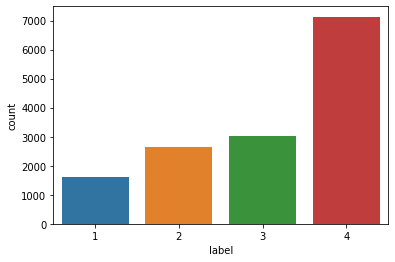

In [4]:
sns.countplot(df['label'])

In [5]:
df['label'].value_counts()

4    7131
3    3035
2    2652
1    1616
Name: label, dtype: int64

Label structure is as follows:  

1: positive reaction  
2: negative reaction  
3: joke or meme  
4: irrelevant

Let's explore each label in depth.

**Positive Comments**

In [6]:
positives = df[df['label'] == 1]

In [7]:
positives.head()

,subject,comment,label
22,Allen,I think its a great pick at 7,1
27,Allen,I'd go for steal tbh,1
28,Allen,Best QB in the draft by far,1
29,Allen,Yes,1
35,Allen,I'm glad the Bills got him. I was afraid Elway...,1


In [8]:
pos_text = ' '.join(list(positives['comment']))

In [9]:
wordcloud = WordCloud(max_words=30, background_color='white', width=1000, height=500,
                                  colormap='coolwarm').generate(pos_text)

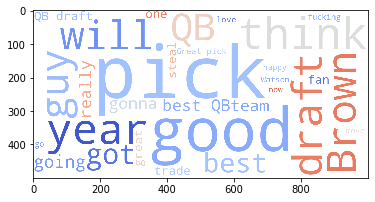

In [10]:
plt.imshow(wordcloud)

There are some interesting trends here:  

(1) There are a lot of evaluation words: good, best, great, happy  
(2) There are a lot of very specific terms/lingo: steal (a good price for a pick), QB, trade (probably assessing the value of a trade up to draft a quarterback)  
(3) Words about the future: gonna, go, will  
(4) A couple of specific names: Brown (the Cleveland Browns), Watson (Deshaun Watson)  
(5) One expletive  

Let's see who got the most positive comments:

In [11]:
df[df['label'] == 1]['subject'].value_counts()

Watson      250
Rosen       241
Haskins     175
Jackson     147
Darnold     133
Mayfield    126
Trubisky    107
Kizer       105
Mahomes      98
Jones        92
Murray       87
Allen        55
Name: subject, dtype: int64

Deshaun Watson and Josh Rosen were the most positively reviewed draftees!

**Negative Comments**

In [12]:
negatives = df[df['label'] == 2]

In [13]:
negatives.head()

,subject,comment,label
5,Allen,Lol,2
18,Allen,With Rosen still on the board I gotta think th...,2
21,Allen,mistake,2
23,Allen,I am; mistake lol,2
32,Allen,I'm leaning towards big mistake. I would have ...,2


In [14]:
neg_text = ' '.join(list(negatives['comment']))

In [15]:
wordcloud = WordCloud(max_words=30, background_color='white', width=1000, height=500,
                                  colormap='coolwarm').generate(neg_text)

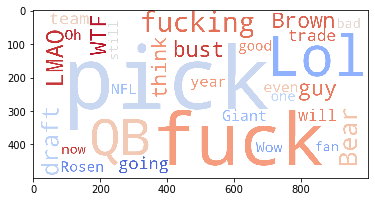

In [16]:
plt.imshow(wordcloud)

Wow, lots of profanity!  This is useful, since it expresses a clear emotion: anger.  There are also some interesting words, like "bust," "bad," "wow," and "oh."  A lot of these work as single-word reactions to draft picks.  Let's look at how the length of the comments varies between positive and negative comments:

In [17]:
print(len(pos_text.split(' ')))
print(len(neg_text.split(' ')))

26305
24718


There are more total words in positive comments than negative comments!  Let's look at the average length of each comment for positive and negative comments:

In [18]:
pos_lengths = []
neg_lengths = []

for comment in positives['comment']:
    pos_lengths.append(len(comment.split(' ')))
    
for comment in negatives['comment']:
    neg_lengths.append(len(comment.split(' ')))

<BarContainer object of 2 artists>

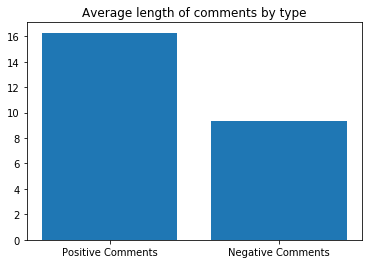

In [19]:
plt.title('Average length of comments by type')
plt.bar(['Positive Comments', 'Negative Comments'],[np.average(pos_lengths), np.average(neg_lengths)])

On average, positive comment are significantly longer than negative comments!  It appears that most negative comments are simple reactions!  Let's explore negative comments that are one word in length:

In [33]:
one_word_comments = []

for comment in negatives['comment']:
    if len(comment.split(' ')) == 1:
        one_word_comments.append(comment)
        
print(len(one_word_comments))

764


There are 764 one-word negative comments.  Let's dig a bit deeper and make a word cloud:

In [34]:
one_word_text = ' '.join(one_word_comments)

In [35]:
wordcloud = WordCloud(max_words=30, background_color='white', width=1000, height=500,
                                  colormap='coolwarm').generate(one_word_text)

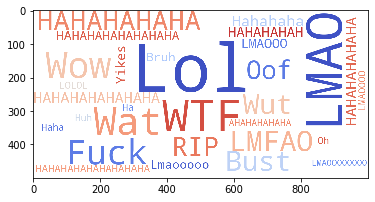

In [36]:
plt.imshow(wordcloud)

Lots of these one-word comments have to do with laughing: "haha"s, "lmao," "lmfao," "lol," etc.  Lots also have to do with astonishment: "wtf," "bruh," "wat," "yikes," "wut."  Consolidating a lot of these comments into a standard form will be essential to producing a robust model!


**Consolidating One-Word Comments**

Let's make an effort to consolidate these one-word comments and see what we get!  Let's start by seeing how many different one-word comments we really have.  

We start by making everything lowercase:

In [37]:
one_word_comments = [str.lower(x) for x in one_word_comments]

In [38]:
pd.DataFrame(one_word_comments, columns=['text'])['text'].nunique()

291

There are 291 unique one-word comments.  Let's try and reduce this!  Let's start by cutting down words that have repeated letters (like looooool, hahahahahahaha, and lmaooooooo):

In [39]:
import re

In [40]:
def clean_text(text):
    cleaned = re.sub(r'lo[o]*l[l]*([o]+|[l]+)+', 'lol', text)
    cleaned = re.sub(r'lo[o]+l', 'lol', cleaned)
    cleaned = re.sub(r'lol[a-z]+', 'lol', cleaned)
    cleaned = re.sub(r'l[e]+[l]', 'lol', cleaned)
    cleaned = re.sub(r'rofl[rofl]+', 'rofl', cleaned)
    
    cleaned = re.sub(r'lm[m]*[f]*a[a]*[o]+', 'lmao', cleaned)
    
    cleaned = re.sub(r'[b]*[w]*[a]*haha([a]+|[h]+)+', 'haha', cleaned)
    
    cleaned = re.sub(r'w(u|a)[t]+', 'what', cleaned)
    cleaned = re.sub(r'wh[h]*a[a]*t[t]*', 'what', cleaned)
    
    cleaned = re.sub('ew[w]+', 'ew', cleaned)
    cleaned = re.sub('ugh[h]+', 'ugh', cleaned)
    
    cleaned = re.sub('boo[o]+', 'boo', cleaned)
    
    cleaned = re.sub('f[f]*u[u]*c[c]*k[k]*', 'fuck', cleaned)
    
    cleaned = re.sub('oh[h]+', 'oh', cleaned)
    cleaned = re.sub('uh[h]+', 'uh', cleaned)
    cleaned = re.sub('a[a]*h[h]*', 'ah', cleaned)
    
    cleaned = re.sub('wt[t]*f[f]*', 'wtf', cleaned)
    
    cleaned = re.sub('wo[o]*w[w]*', 'wow', cleaned)
    
    cleaned = re.sub('no[o]+', 'no', cleaned)
    cleaned = re.sub('no[no]+', 'no', cleaned)
    
    cleaned = re.sub('oo[o]*ps[s]*', 'oops', cleaned)
    
    cleaned = re.sub('bu[u]*s[s]*t[t]*', 'bust', cleaned)
    
    return cleaned

In [41]:
one_word_comments = [clean_text(x) for x in one_word_comments]

In [42]:
pd.DataFrame(one_word_comments, columns=['text'])['text'].nunique()

146

Let's visualize this once again:

In [116]:
one_word_text = ' '.join(one_word_comments)

In [117]:
wordcloud = WordCloud(max_words=30, background_color='white', width=1000, height=500,
                                  colormap='coolwarm').generate(one_word_text)

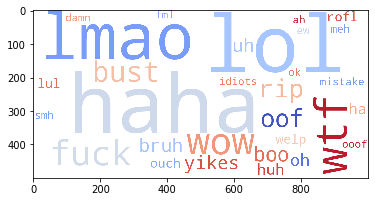

In [118]:
plt.imshow(wordcloud)

Fantastic!  We cut down the number of unique comments to 139.  Finally, let's look at who got the most hate from r/NFL users:

In [61]:
df[df['label'] == 2]['subject'].value_counts()

Jones       879
Trubisky    611
Murray      240
Mayfield    216
Mahomes     213
Allen       161
Haskins      65
Watson       63
Jackson      60
Darnold      58
Kizer        52
Rosen        34
Name: subject, dtype: int64

Daniel Jones and Mitchell Trubisky were the players most hated by r/NFL!

**Joke Comments**

Let's explore a bit about joke comments:

In [54]:
jokes = df[df['label'] == 3]

In [55]:
jokes.head()

,subject,comment,label
6,Allen,“let’s draft josh” “which one” “idk let’s se...,3
8,Allen,cant believe they did it. big night for the PM...,3
13,Allen,Accept Sonic.,3
14,Allen,Nobody showed up to Josh Rosen's birthday party,3
17,Allen,Josh Allen will either be very good or very ba...,3


In [56]:
joke_text = ' '.join(list(jokes['comment']))

In [57]:
wordcloud = WordCloud(max_words=30, background_color='white', width=1000, height=500,
                                  colormap='coolwarm').generate(joke_text)

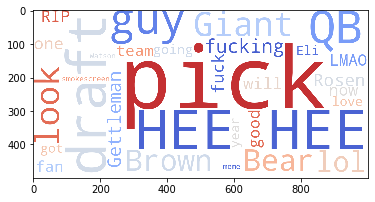

In [58]:
plt.imshow(wordcloud)

One very noticable combination is "Hee hee."  This is a joke relating to Baker Mayfield when he visited Cleveland's practice facilities (you can read about the origin of the meme [here](https://www.sbnation.com/2018/4/26/17288584/browns-baker-mayfield-pied-piper-hee-hee-hue-jackson)).  Let's see which player got the most joke comments:

In [59]:
df[df['label'] == 3]['subject'].value_counts()

Jones       794
Mayfield    421
Murray      373
Trubisky    282
Jackson     245
Haskins     184
Mahomes     170
Watson      139
Allen       122
Rosen       120
Darnold     113
Kizer        72
Name: subject, dtype: int64

Daniel Jones got the most joke comments (probably why "Eli," referring to Eli Manning, shows up in the word cloud).  There were a lot of jokes that Daniel Jones looks a lot like Eli Manning, hence all the joke comments.  Baker Mayfield, with the "Hee Hee" meme appears next.  DeShone Kizer, interestingly enough, got very few joke comments.

**Irrelevant Comments**

Unfortunately, irrelevant/off topic comments made up the majority of the comments scraped.  Let's look at why that happened:

In [62]:
off_topic = df[df['label'] == 4]

In [63]:
off_topic.head()

,subject,comment,label
0,Allen,Good trade. With those extra 2nd round picks t...,4
1,Allen,@buffalobills > 2018-04-27 00:52 +00:00 > T...,4
2,Allen,Oh well that's not very much.,4
3,Allen,Damn son.,4
4,Allen,BUFBills receive| TBBuccaneers receive ---|-...,4


In [64]:
irr_text = ' '.join(list(off_topic['comment']))

In [65]:
wordcloud = WordCloud(max_words=30, background_color='white', width=1000, height=500,
                                  colormap='coolwarm').generate(irr_text)

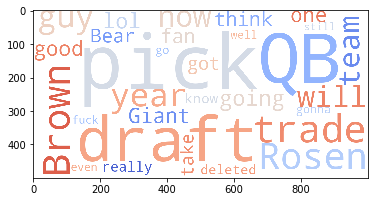

In [66]:
plt.imshow(wordcloud)

A couple of things to note:

(1) deleted comments were considered off-topic  
(2) Lots of specific names: "Brown," "Rosen," "Giant," "Bear."  Most of these comments dealt with teams other than the one to which a draftee was selected (ex. many Josh Rosen comments talked about other teams that DIDN'T draft him).  
(3) Lots of thoughts: "think," "now" (i.e. what will happen next in the draft), "take" (as in which player will be taken next), "will" (what will happen next), "know" (we don't know), "still" (as in player X is still in the draft)  
(4) Asking for fan reactions: "Giants fans, how do you feel about this pick?"  
(5) LOTS of trade talk: reactions to trades rather than the draft picks.  For example, many teams traded up to get quarterbacks: the fans love the players, but hate how much was sacrificed in trades to get a higher pick spot; this is not a reaction to the player, but to team strategy.  
(6) "draft:" reactions to the draft as a whole were comment (i.e. "this draft is wild!").

Let's look at who got the most irrelevant comments:

In [67]:
df[df['label'] == 4]['subject'].value_counts()

Jones       1400
Trubisky     945
Murray       871
Mayfield     618
Haskins      524
Mahomes      478
Watson       458
Jackson      437
Allen        428
Kizer        360
Darnold      333
Rosen        279
Name: subject, dtype: int64